In [218]:
from src.datagen import get_decks, sample_decks
from src.processing import game, simulate
from src.visualize import visualize
import numpy as np
import random
HALF_DECK_SIZE = 26

In [ ]:
decks = sample_decks(1000000, 1)

In [3]:
sim = simulate(decks)
sim[4]

10

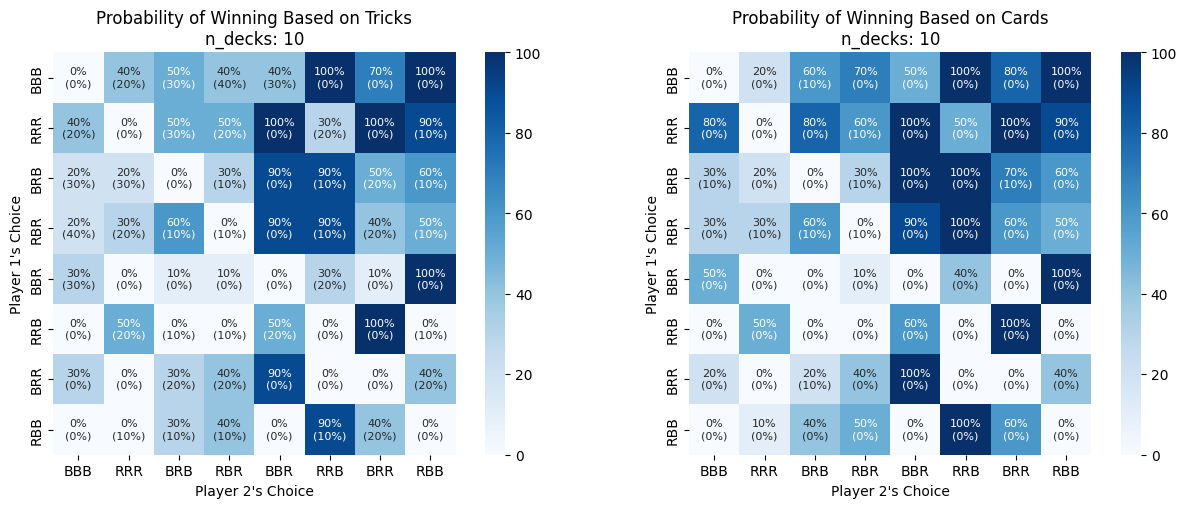

In [4]:
visualize(sim)

In [51]:
decks = sample_decks(1000000, 'data/decks_test.npy')

In [52]:
visualize(simulate(decks))

KeyboardInterrupt: 

In [30]:
import os
def get_decks(n_decks: int,
              seed: int,
              half_deck_size: int = HALF_DECK_SIZE) -> None:
    """
    Efficiently generate `n_decks` shuffled decks using NumPy.
    Saves the details of the deck in a dictionary in a separate .npy file.
    
    Returns:
        decks (np.ndarray): 2D array of shape (n_decks, num_cards), each row is a shuffled deck.
    """
    filename = 'data/decks_'+str(seed)+'.npy'
    if filename in os.listdir('data/'):
        print(f"A file with seed {seed} already exists. Choose another seed.")
        return
    else:
        init_deck = [0]*half_deck_size + [1]*half_deck_size
        decks = np.tile(init_deck, (n_decks, 1))
        rng = np.random.default_rng(seed)
        rng.permuted(decks, axis=1, out=decks)
        np.save(filename, decks)
        deck_dict = dict(n_decks = n_decks,
                        seed = seed,
                        half_deck_size = half_deck_size,
                        decks = decks)
        np.save('data/deck_dict_'+str(seed)+'.npy', decks)
        return decks

In [59]:
decks = get_decks(5, 3, 5)
decks

In [60]:
decks = sample_decks(5, 'data/decks_3.npy')
decks

array([[1, 1, 0, 0, 0, 0, 1, 1, 0, 1],
       [0, 1, 0, 1, 1, 0, 0, 1, 1, 0],
       [0, 0, 0, 1, 1, 0, 0, 1, 1, 1],
       [1, 0, 0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 0, 0, 1, 1, 1, 0, 1]])

In [225]:
from datetime import datetime as dt
from typing import Callable
DEBUG = True

def debugger_factory(show_args=True) -> Callable:
    def debugger(func: Callable) -> Callable:
        if DEBUG:
            def wrapper(*args, **kwargs):
                if show_args:
                    print(f'{func.__name__} was called with:')  # Functions know their own names
                    print('Positional arguments: \n', args)
                    print('Keyword arguments: \n', kwargs)
        
                t0 = dt.now()
                results = func(*args, **kwargs)
                print(f'{func.__name__} ran for {dt.now()-t0}')
                return results
        else:
            return func
        return wrapper
    return debugger

In [226]:
choices = {'BBB': [0,0,0],
             'RRR': [1,1,1],
             'BRB': [0,1,0],
             'RBR': [1,0,1],
             'BBR': [0,0,1],
             'RRB': [1,1,0],
             'BRR': [0,1,1],
             'RBB': [1,0,0]}

@debugger_factory(show_args=False)
def game(p1_choice: str,
         p2_choice: str,
         decks: np.ndarray
         ) -> list[list, list]:
    """
    Simulate the game of Penney and store results.

    Arugments:
        p1_choice: player 1's card selection
        p2_choice: player 2's card selection,
        deck: chosen deck to simulate the game
    
    """
    p1_choice, p2_choice = choices[p1_choice], choices[p2_choice]

    # Initialize counters for wins by tricks, wins by cards, draws by tricks, and draws by cards
    p2_wins_tricks, p2_wins_cards = 0, 0
    draw_tricks, draw_cards = 0, 0

    # PLAY THE GAME
    for deck in decks: # Loop through each deck
        p1_tricks, p2_tricks, p1_cards, p2_cards = 0, 0, 0, 0
        trick = list(deck[:2])

        for i in range(2, len(deck)):
            trick.append(deck[i]) # Add the 3rd (then next) card

            if len(trick) >= 3:
                last_three = trick[-3:]
            
                # CHECK FOR A P1 WIN
                if last_three == list(p1_choice): # If p1 wins, update p1's trick and card counts and refresh trick
                    p1_tricks += 1
                    p1_cards += len(trick)
                    trick = []

                # CHECK FOR A P2 WIN
                elif last_three == list(p2_choice): # If p2 wins, update p1's trick and card counts and refresh trick
                    p2_tricks += 1
                    p2_cards += len(trick)
                    trick = []
                    
        # SCORE THE GAME BY TRICKS
        if p2_tricks > p1_tricks:
            p2_wins_tricks += 1
        elif p2_tricks == p1_tricks:
            draw_tricks += 1
        
        # SCORE THE GAME BY CARDS 
        if p2_cards > p1_cards:
            p2_wins_cards += 1
        elif p2_cards == p1_cards:
            draw_cards += 1

    # COMPUTE THE PROBABILITIES
    total_games = len(decks)
    prob_win_tricks = round((p2_wins_tricks / total_games) * 100, 2)
    prob_draw_tricks = round((draw_tricks / total_games) * 100, 2)
    prob_win_cards = round((p2_wins_cards / total_games) * 100, 2)
    prob_draw_cards = round((draw_cards / total_games) * 100, 2)
    
    return [prob_win_tricks, prob_draw_tricks, prob_win_cards, prob_draw_cards]


In [227]:
choices = {'BBB': [0,0,0],
             'RRR': [1,1,1],
             'BRB': [0,1,0],
             'RBR': [1,0,1],
             'BBR': [0,0,1],
             'RRB': [1,1,0],
             'BRR': [0,1,1],
             'RBB': [1,0,0]}
             
@debugger_factory(show_args=False)
def simulate(deck: np.ndarray) -> list:
    """
    Produce simulations of Penney's game and save the results.
    Output: A list storing Player 1 and 2's tricks and cards.
    
    Arguments:
        deck = Array of decks to be simulated   
    """
    # Initalize external counters for the probabilities
        # annot_tricks and annot_cards hold the same probabilities but with the draw percentage in parentheses
    n_decks = len(deck)
    games_tricks, games_cards, annot_tricks, annot_cards = [], [], [], []
    
    # Loop through each choice for Player 1
    for p1_choice in choices:
        
        # Internal counter initializations but for each of Player 1's choices
        prob_tricks, prob_cards, prob_tricks_annot, prob_cards_annot = [], [], [], []
        
        # Play the game against Player 1's choice with every option for Player 2         
        for p2_choice in choices:
            if p1_choice == p2_choice:
                    prob_tricks.append(np.nan)
                    prob_cards.append(np.nan)
                    prob_tricks_annot.append("")
                    prob_cards_annot.append("")
            elif p1_choice != p2_choice:
                    win_tricks, draw_tricks, win_cards, draw_cards = game(p1_choice, p2_choice, deck)

                    # Add probabilities to the external counters
                    prob_tricks.append(win_tricks)
                    prob_cards.append(win_cards)

                    # Create annotations for the probabilities
                    prob_tricks_annot.append(str(win_tricks) + '%\n(' + str(draw_tricks) + '%)')
                    prob_cards_annot.append(str(win_cards) + '%\n(' + str(draw_cards) + '%)')

        # Add the probabilities for Player 1's choice to the external counters
        games_tricks.append(prob_tricks)
        games_cards.append(prob_cards)
        annot_tricks.append(prob_tricks_annot)
        annot_cards.append(prob_cards_annot)

    return [games_tricks, annot_tricks, games_cards, annot_cards, n_decks]

In [ ]:
deck = sample_decks(10000, 'data/decks_test.npy')
choices = {'BBB': [0,0,0],
             'RRR': [1,1,1],
             'BRB': [0,1,0],
             'RBR': [1,0,1],
             'BBR': [0,0,1],
             'RRB': [1,1,0],
             'BRR': [0,1,1],
             'RBB': [1,0,0]}
p1_choice = 'BBB'


In [ ]:
#p2_choice = 'BBB'


In [214]:
games_tricks, games_cards, annot_tricks, annot_cards = [], [], [], []
for p1_choice in choices:
        prob_tricks, prob_cards, prob_tricks_annot, prob_cards_annot = [], [], [], []
        for p2_choice in choices:
                if p1_choice == p2_choice:
                        prob_tricks.append(np.nan)
                        prob_cards.append(np.nan)
                        prob_tricks_annot.append("")
                        prob_cards_annot.append("")
                elif p1_choice != p2_choice:
                        win_tricks, draw_tricks, win_cards, draw_cards = game(p1_choice, p2_choice, deck)

                        # Add probabilities to the external counters
                        prob_tricks.append(win_tricks)
                        prob_cards.append(win_cards)

                        # Create annotations for the probabilities
                        prob_tricks_annot.append(str(win_tricks) + '%\n(' + str(draw_tricks) + '%)')
                        prob_cards_annot.append(str(win_cards) + '%\n(' + str(draw_cards) + '%)')
        games_tricks.append(prob_tricks)
        games_cards.append(prob_cards)
        annot_tricks.append(prob_tricks_annot)
        annot_cards.append(prob_cards_annot)

In [215]:
games_tricks

[[nan, 32.65, 65.85, 69.21, 44.68, 96.87, 76.84, 99.47],
 [32.27, nan, 69.49, 65.9, 96.69, 44.43, 99.46, 77.48],
 [21.27, 16.67, nan, 40.19, 79.76, 79.23, 43.05, 44.27],
 [17.16, 21.87, 41.12, nan, 79.19, 79.54, 43.6, 43.82],
 [39.65, 0.9, 11.67, 11.33, nan, 40.13, 5.13, 93.59],
 [0.8, 40.38, 11.57, 11.85, 41.6, nan, 93.45, 5.29],
 [11.62, 0.07, 43.27, 42.84, 88.28, 2.84, nan, 43.71],
 [0.12, 11.39, 42.94, 42.69, 2.54, 87.9, 43.04, nan]]

In [212]:
games_tricks.append(prob_tricks)
games_tricks

[[nan, 32.65, 65.85, 69.21, 44.68, 96.87, 76.84, 99.47]]

In [ ]:
for p2_choice in choices:
    print(p2_choice)

BBB
RRR
BRB
RBR
BBR
RRB
BRR
RBB


In [228]:
outcome = game(p1_choice, p2_choice, deck)
outcome

game ran for 0:00:00.227191


[0.0, 0.0, 0.0, 0.0]

In [194]:
prob_tricks.append(outcome[0])
prob_tricks

[99.43]

In [183]:
prob_tricks

[nan,
 33.45,
 64.89,
 68.75,
 44.34,
 96.69,
 77.11,
 99.43,
 nan,
 33.45,
 64.89,
 68.75,
 44.34,
 96.69,
 77.11,
 99.43]

In [231]:
import zipfile
with zipfile.ZipFile('data/testing_decks.zip', 'w') as myzip:
    myzip.write('data/decks_test.npy')

In [130]:
decks = [0,1,2,3,4,5]
trick = list(decks[:2])

for i in range(2, len(decks)):
    print(i)
    trick.append(decks[i])
    trick
#i=3

#trick.append(decks[0][i])
#trick = list(decks[0][i+1:i+3])


#trick[-3:]
trick

2
3
4
5


[0, 1, 2, 3, 4, 5]

In [137]:
choices = {'BBB': [0,0,0],
             'RRR': [1,1,1],
             'BRB': [0,1,0],
             'RBR': [1,0,1],
             'BBR': [0,0,1],
             'RRB': [1,1,0],
             'BRR': [0,1,1],
             'RBB': [1,0,0]}

p1_choice = 'BBB'
p2_choice = 'RBB'
p1_choice, p2_choice = choices[p1_choice], choices[p2_choice]
print(p1_choice)
print(p2_choice)

[0, 0, 0]
[1, 0, 0]


In [128]:
len(decks[0])

52

In [229]:
simulate(decks)

game ran for 0:00:00.218053
game ran for 0:00:00.309620
game ran for 0:00:00.222798
game ran for 0:00:00.207634
game ran for 0:00:00.198654
game ran for 0:00:00.193252
game ran for 0:00:00.206906
game ran for 0:00:00.220292
game ran for 0:00:00.191697
game ran for 0:00:00.197536
game ran for 0:00:00.189821
game ran for 0:00:00.196120
game ran for 0:00:00.201710
game ran for 0:00:00.191894
game ran for 0:00:00.193385
game ran for 0:00:00.193999
game ran for 0:00:00.204717
game ran for 0:00:00.194186
game ran for 0:00:00.181588
game ran for 0:00:00.181226
game ran for 0:00:00.195894
game ran for 0:00:00.192955
game ran for 0:00:00.197795
game ran for 0:00:00.205016
game ran for 0:00:00.271874
game ran for 0:00:00.193446
game ran for 0:00:00.195679
game ran for 0:00:00.187791
game ran for 0:00:00.211724
game ran for 0:00:00.192470
game ran for 0:00:00.199290
game ran for 0:00:00.192703
game ran for 0:00:00.192694
game ran for 0:00:00.236795
game ran for 0:00:00.204765
game ran for 0:00:00

[[[nan, 32.78, 66.85, 68.88, 44.38, 96.74, 77.01, 99.46],
  [32.46, nan, 69.35, 66.22, 97.01, 44.38, 99.61, 77.33],
  [21.42, 16.95, nan, 41.1, 80.29, 78.97, 43.07, 44.49],
  [16.49, 20.89, 40.37, nan, 79.19, 79.76, 44.5, 43.43],
  [40.39, 0.68, 11.47, 11.53, nan, 41.0, 5.4, 93.82],
  [0.73, 39.62, 11.33, 11.89, 40.92, nan, 93.55, 5.09],
  [11.31, 0.06, 42.86, 41.68, 88.01, 2.48, nan, 42.97],
  [0.09, 10.88, 42.31, 43.03, 2.4, 88.24, 43.18, nan]],
 [['',
   '32.78%\n(34.76%)',
   '66.85%\n(11.73%)',
   '68.88%\n(14.63%)',
   '44.38%\n(15.23%)',
   '96.74%\n(2.53%)',
   '77.01%\n(11.68%)',
   '99.46%\n(0.45%)'],
  ['32.46%\n(34.76%)',
   '',
   '69.35%\n(13.7%)',
   '66.22%\n(12.89%)',
   '97.01%\n(2.31%)',
   '44.38%\n(16.0%)',
   '99.61%\n(0.33%)',
   '77.33%\n(11.79%)'],
  ['21.42%\n(11.73%)',
   '16.95%\n(13.7%)',
   '',
   '41.1%\n(18.53%)',
   '80.29%\n(8.24%)',
   '78.97%\n(9.7%)',
   '43.07%\n(14.07%)',
   '44.49%\n(13.2%)'],
  ['16.49%\n(14.63%)',
   '20.89%\n(12.89%)',
   '40.

In [119]:
game('RRR', 'BBB', decks)

[30.0, 45.0, 53.0, 1.0]

In [71]:
#prob_win_tricks = round(3 / len(decks))
round((3/len(decks))*100, 2)

60.0

In [39]:
trick = np.array([])
trick = decks[0][:2] # Add first 2 cards to trick
trick

array([1, 0])

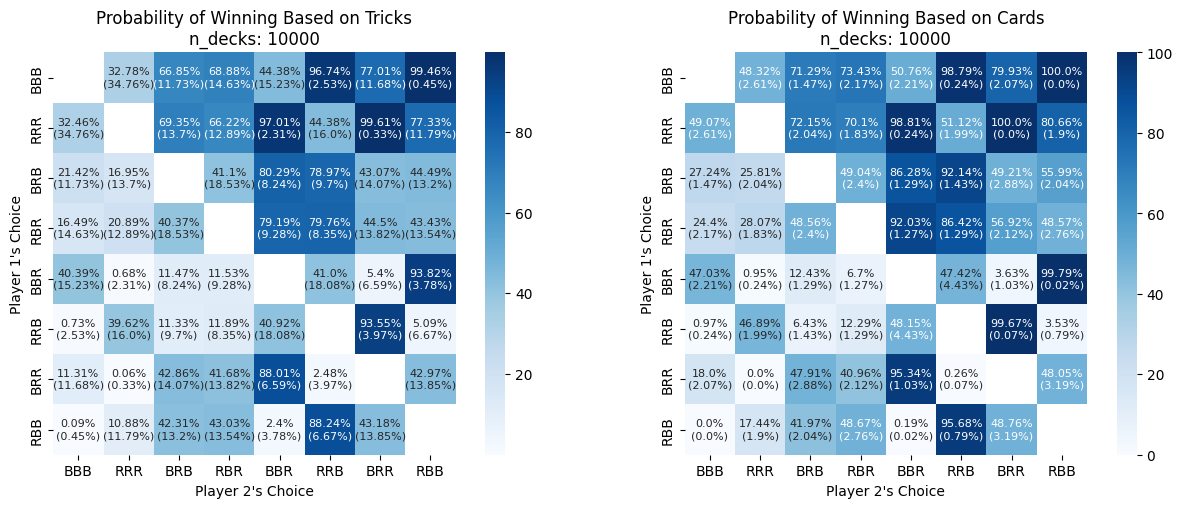

In [222]:
decks = sample_decks(10000, 'data/decks_test.npy')
visualize(simulate(decks))

In [224]:
type(games_cards)

list

In [110]:
sim = simulate(decks)
sim

[[[nan, 10.4, 11.5, 7.9, 8.2, 9.6, 9.7, 10.9],
  [8.4, nan, 7.6, 11.0, 9.8, 10.6, 9.5, 11.0],
  [8.1, 13.5, nan, 10.4, 8.6, 9.5, 10.2, 11.1],
  [11.0, 10.5, 10.3, nan, 8.5, 9.6, 9.9, 11.4],
  [11.1, 13.5, 12.6, 12.3, nan, 13.1, 13.1, 14.8],
  [11.7, 13.5, 12.6, 12.3, 11.7, nan, 13.1, 14.8],
  [11.6, 14.5, 12.6, 12.3, 11.7, 13.1, nan, 14.8],
  [12.0, 14.5, 12.6, 12.3, 11.7, 13.1, 13.1, nan]],
 [['',
   '10.4%\n(81.2%)',
   '11.5%\n(80.4%)',
   '7.9%\n(81.1%)',
   '8.2%\n(80.7%)',
   '9.6%\n(78.7%)',
   '9.7%\n(78.7%)',
   '10.9%\n(77.1%)'],
  ['8.4%\n(81.2%)',
   '',
   '7.6%\n(78.9%)',
   '11.0%\n(78.5%)',
   '9.8%\n(76.7%)',
   '10.6%\n(75.9%)',
   '9.5%\n(76.0%)',
   '11.0%\n(74.5%)'],
  ['8.1%\n(80.4%)',
   '13.5%\n(78.9%)',
   '',
   '10.4%\n(79.3%)',
   '8.6%\n(78.8%)',
   '9.5%\n(77.9%)',
   '10.2%\n(77.2%)',
   '11.1%\n(76.3%)'],
  ['11.0%\n(81.1%)',
   '10.5%\n(78.5%)',
   '10.3%\n(79.3%)',
   '',
   '8.5%\n(79.2%)',
   '9.6%\n(78.1%)',
   '9.9%\n(77.8%)',
   '11.4%\n(76.3%)'],

In [111]:
game('BBB', 'RBB', decks)

[10.9, 77.1, 10.9, 77.1]